In [1]:
import yfinance as yf
import pandas as pd
import pandas_datareader.data as web
import numpy as np
import itertools
import seaborn as sns
import matplotlib.pyplot as plt

In [2]:
def get_data(ticker, start, end, interval="1d"):
    """
    Downloads historical data.
    """
    df = yf.download(ticker, start=start, end=end, interval=interval, progress=False)

    # Handle multi-index columns if yfinance returns them
    if isinstance(df.columns, pd.MultiIndex):
        try:
            # Try to select the 'Close' column for the specific ticker
            # If the multi-index is (Price, Ticker), we need to be careful
            if 'Close' in df.columns.levels[0]:
                 df = df['Close']
            else:
                 # Fallback: just take the first column if structure is unexpected
                 df = df.iloc[:, 0].to_frame(name='Close')
        except:
             df = df.iloc[:, 0].to_frame(name='Close')
    else:
        # Standard dataframe
        if 'Close' in df.columns:
            df = df[['Close']]
        else:
             # Fallback if 'Close' isn't exact match (e.g. 'Adj Close')
             df = df.iloc[:, 0].to_frame(name='Close')

    # Ensure column is named 'Close' for the rest of the script
    df.columns = ['Close'] if len(df.columns) == 1 else df.columns
    return df.dropna()

In [3]:
import pandas_datareader.data as web
import pandas as pd
import numpy as np

def get_macro_data(start_date, end_date):
    """
    Fetches GDP and Current Account (Trade Proxy) for US and Euro Area.
    Uses a 'Net Score' approach to avoid conflicting signals.
    """
    print("Fetching Macro Data (GDP + Current Account)...")

    # 1. DEFINE TICKERS
    tickers = {
        'US_GDP':    'GDP',                # US GDP (Billions $)
        'EU_GDP':    'CLVMNACSCAB1GQEU28', # Euro Area GDP (Real, Index)

        # US Current Account (Billions $)
        'US_CA':     'IEABC',
        # Euro Area Current Account (% of GDP) - THIS IS THE WORKING TICKER
        'EU_CA_Pct': 'EA19B6BLTT02STSAQ',
    }

    try:
        data = web.DataReader(list(tickers.values()), 'fred', start_date, end_date)
        data.columns = list(tickers.keys())
        data = data.resample('D').ffill()

        # 2. NORMALIZE DATA (Apples to Apples)

        # A. GDP Growth (Year over Year)
        # We use 252 days (1 trading year) to smooth out noise
        data['US_Growth'] = data['US_GDP'].pct_change(252)
        data['EU_Growth'] = data['EU_GDP'].pct_change(252)

        # B. Current Account (Convert US to % of GDP to match EU)
        # Formula: (Net Foreign Investment / GDP) * 100
        data['US_CA_Pct'] = (data['US_CA'] / data['US_GDP']) * 100

        # 3. CALCULATE SCORES

        # Score 1: Growth Differential (If EU grows faster -> Positive Score)
        data['Growth_Diff'] = data['EU_Growth'] - data['US_Growth']

        # Score 2: Trade Differential (If EU runs larger surplus -> Positive Score)
        data['Trade_Diff'] = data['EU_CA_Pct'] - data['US_CA_Pct']

        # 4. FINAL SIGNAL (Weighted Sum)
        # We give equal weight to Growth and Trade.
        # If Total > 0, Fundamentals favor EUR.
        data['Total_Score'] = data['Growth_Diff'] + data['Trade_Diff']

        # Create Binary Signal for the strategy
        # 1 = Bullish EUR, -1 = Bearish EUR (Long USD)
        data['Macro_Signal'] = np.where(data['Total_Score'] > 0, 1, -1)

        print("Macro Data fetched successfully.")
        print(f"Signal Distribution: \n{data['Macro_Signal'].value_counts()}")

        return data[['Macro_Signal']]

    except Exception as e:
        print(f"Error: {e}")
        # Fallback: Return all 1s (Long Only) if data fails, just to keep code running
        print("Using Fallback Signal (1).")
        dates = pd.date_range(start=start_date, end=end_date)
        return pd.DataFrame({'Macro_Signal': 1}, index=dates)

In [4]:
def calculate_metrics(equity_curve, trade_log):
    """
    Computes performance metrics including Avg Win/Loss Ratio.

    Parameters:
    - equity_curve: Pandas Series representing the account balance over time.
    - trade_log: Can be a list/Series of PnL values OR a DataFrame with 'Entry_Price' and 'Exit_Price'.
    """

    # --- 1. Pre-process trade_log to ensure we have a list of PnL values ---
    if isinstance(trade_log, pd.DataFrame):
        # If it's a DataFrame and PnL is missing, create it
        if 'pnl' not in trade_log.columns:
            try:
                # Assuming standard column names; adjust if yours differ (e.g. 'Close', 'Open')
                pnl_values = trade_log['Exit_Price'] - trade_log['Entry_Price']
            except KeyError:
                print("Error: DataFrame missing 'Exit_Price' or 'Entry_Price'.")
                pnl_values = []
        else:
            pnl_values = trade_log['pnl']

        # Convert to list for the logic below
        trades = pnl_values.tolist()
    else:
        # Assume it's already a list/Series of PnL values
        trades = list(trade_log)

    # --- 2. Existing Metrics Logic ---
    daily_returns = equity_curve.pct_change().dropna()
    total_return = (equity_curve.iloc[-1] / equity_curve.iloc[0]) - 1
    days = (equity_curve.index[-1] - equity_curve.index[0]).days
    annual_return = ((1 + total_return) ** (365.0 / max(1, days))) - 1
    annual_volatility = daily_returns.std() * np.sqrt(252)

    if annual_volatility == 0:
        sharpe_ratio = 0
    else:
        sharpe_ratio = daily_returns.mean() / daily_returns.std() * np.sqrt(252)

    rolling_max = equity_curve.cummax()
    drawdown = (equity_curve - rolling_max) / rolling_max
    max_drawdown = drawdown.min()

    # --- 3. Win/Loss Analysis ---
    if len(trades) > 0:
        winners = [t for t in trades if t > 0]
        losers = [t for t in trades if t < 0]

        hit_rate = len(winners) / len(trades)

        avg_win = np.mean(winners) if winners else 0
        avg_loss = np.mean(losers) if losers else 0

        # Calculate Ratio (Use abs to keep ratio positive: e.g. 100 / |-50| = 2.0)
        if avg_loss != 0:
            win_loss_ratio = avg_win / abs(avg_loss)
        else:
            win_loss_ratio = 0 # Or np.inf if you prefer
    else:
        hit_rate = 0.0
        avg_win = 0.0
        avg_loss = 0.0
        win_loss_ratio = 0.0

    return {
        "Annual Return": annual_return,
        "Annual Volatility": annual_volatility,
        "Sharpe Ratio": sharpe_ratio,
        "Max Drawdown": max_drawdown,
        "Hit Rate": hit_rate,
        "Total Trades": len(trades),
        "Avg Win": avg_win,
        "Avg Loss": avg_loss,
        "Win/Loss Ratio": win_loss_ratio
    }

In [5]:
def run_strategy(data, macro_df, alpha, beta, threshold=0.001, decel_rate=0.0005, initial_capital=10000):
    df = data.copy()

    # 1. Indicators
    df['es_slow'] = df['Close'].ewm(alpha=alpha, adjust=False).mean()
    df['es_fast'] = df['Close'].ewm(alpha=beta, adjust=False).mean()
    df['diff'] = df['es_fast'] - df['es_slow']
    df['velocity'] = df['es_fast'].diff()
    df['acceleration'] = df['velocity'].diff()

    # Join Macro Data (Assumes macro_df has a column 'Macro_Signal' with 1, -1, or 0)
    df = df.join(macro_df[['Macro_Signal']], how='left').ffill()

    # 2. Variables
    position = 0
    entry_price = 0.0
    equity = [initial_capital] * len(df)
    trade_log = []
    trade_dates = []
    trade_types = []
    trade_prices = []

    # 3. Loop
    for i in range(2, len(df)):
        curr_price = df['Close'].iloc[i]
        prev_price = df['Close'].iloc[i-1]
        date = df.index[i]

        curr_diff = df['diff'].iloc[i]
        prev_diff = df['diff'].iloc[i-1]
        curr_accel = df['acceleration'].iloc[i]

        # Get Macro Signal (1=Bullish, -1=Bearish, 0=Neutral)
        macro_signal = df['Macro_Signal'].iloc[i]

        # A. Mark-to-Market (Calculate PnL for open positions)
        if position == 1:
            pct_change = (curr_price - prev_price) / prev_price
            equity[i] = equity[i-1] * (1 + pct_change)
        elif position == -1:
            pct_change = (prev_price - curr_price) / prev_price
            equity[i] = equity[i-1] * (1 + pct_change)
        else:
            equity[i] = equity[i-1]

        # B. Exit (Deceleration)
        # Note: Exits generally disregard macro. If momentum dies, get out.
        if position == 1 and curr_accel < -decel_rate:
            trade_log.append(curr_price - entry_price)
            position = 0
            # Optional: Add Exit to trade df for visualization
            trade_dates.append(date)
            trade_types.append('Exit Long')
            trade_prices.append(curr_price)

        elif position == -1 and curr_accel > decel_rate:
            trade_log.append(entry_price - curr_price)
            position = 0
            # Optional: Add Exit to trade df
            trade_dates.append(date)
            trade_types.append('Exit Short')
            trade_prices.append(curr_price)

        # C. Entry (Technical + Macro Confirmation)
        # Only enter if position is currently flat (0) or if reversing (handled below)

        # --- LONG ENTRY ---
        # Technical: Crossover Up AND Macro: Bullish (Signal > 0)
        if prev_diff < 0 and curr_diff > threshold and macro_signal > 0:
            if position == -1: # Close existing short first
                trade_log.append(entry_price - curr_price)

            position = 1
            entry_price = curr_price
            trade_dates.append(date)
            trade_types.append('Buy')
            trade_prices.append(curr_price)

        # --- SHORT ENTRY ---
        # Technical: Crossover Down AND Macro: Bearish (Signal < 0)
        elif prev_diff > 0 and curr_diff < -threshold and macro_signal < 0:
            if position == 1: # Close existing long first
                trade_log.append(curr_price - entry_price)

            position = -1
            entry_price = curr_price
            trade_dates.append(date)
            trade_types.append('Sell')
            trade_prices.append(curr_price)

    df['Equity'] = equity

    # Safety check for empty trade_log before calculating metrics
    if not trade_log:
        trade_log = [0] # Avoid empty list errors

    metrics = calculate_metrics(pd.Series(df['Equity']), trade_log)
    trades_df = pd.DataFrame({'Date': trade_dates, 'Type': trade_types, 'Price': trade_prices})

    return metrics, df, trades_df

In [6]:
def perform_grid_search(data, macro_df, threshold_input, decel_input, step=0.0005):
    """
    Finds optimal Alpha/Beta based on Sharpe Ratio.
    Now accepts user-defined threshold and deceleration.
    """
    r = np.arange(step, 1.0, step)
    results = []

    print(f"Scanning parameters (Step: {step})...")

    best_sharpe = -np.inf
    best_returns = -np.inf
    best_params = {}

    for alpha in r:
        for beta in r:
            if alpha >= beta: continue

            # Pass the user inputs here
            metrics, _, _ = run_strategy(data, macro_df, alpha, beta, threshold=threshold_input, decel_rate=decel_input)

            results.append({
                'alpha': round(alpha, 2),
                'beta': round(beta, 2),
                'Sharpe': metrics['Sharpe Ratio']
            })

            if metrics['Sharpe Ratio'] > best_sharpe:
                best_sharpe = metrics['Sharpe Ratio']
                best_params = {'alpha': alpha, 'beta': beta}

    results_df = pd.DataFrame(results)
    heatmap_data = results_df.pivot(index='alpha', columns='beta', values='Sharpe')

    return heatmap_data, best_params

In [7]:
def plot_heatmap(heatmap_data):
    plt.figure(figsize=(10, 8))
    sns.heatmap(heatmap_data, annot=True, fmt=".2f", cmap="RdYlGn", center=0)
    plt.title("Strategy Sharpe Ratio Heatmap")
    plt.ylabel("Alpha (Slow)")
    plt.xlabel("Beta (Fast)")
    plt.gca().invert_yaxis()
    plt.show()

def plot_trades(df, trade_log):
    fig, (ax1, ax2) = plt.subplots(2, 1, figsize=(14, 10), gridspec_kw={'height_ratios': [2, 1]})

    # Plot 1: Price and Signals
    ax1.plot(df.index, df['Close'], label='Price', color='black', alpha=0.3)
    ax1.plot(df.index, df['es_slow'], label='ES Slow', color='blue', alpha=0.6)
    ax1.plot(df.index, df['es_fast'], label='ES Fast', color='orange', alpha=0.6)

    buys = trade_log[trade_log['Type'] == 'Buy']
    ax1.scatter(buys['Date'], buys['Price'], marker='^', color='green', s=100, label='Buy', zorder=5)

    sells = trade_log[trade_log['Type'] == 'Sell']
    ax1.scatter(sells['Date'], sells['Price'], marker='v', color='red', s=100, label='Sell', zorder=5)

    ax1.set_title("Price, Indicators & Trades")
    ax1.legend()
    ax1.grid(True, alpha=0.3)

    # Plot 2: Equity Curve
    ax2.plot(df.index, df['Equity'], color='purple', label='Strategy Equity')
    ax2.set_title("Equity Curve")
    ax2.grid(True, alpha=0.3)

    plt.tight_layout()
    plt.show()

In [8]:
def visualize_performance(equity_curve, trade_log):
    # Ensure trades are a list of numbers for plotting (same logic as above)
    if isinstance(trade_log, pd.DataFrame):
        if 'pnl' in trade_log.columns:
            trades = trade_log['pnl'].tolist()
        else:
            trades = (trade_log['Exit_Price'] - trade_log['Entry_Price']).tolist()
    else:
        trades = list(trade_log)

    # Create the figure
    fig = plt.figure(figsize=(14, 10))
    gs = fig.add_gridspec(2, 2)

    # Plot 1: Equity Curve (Top, spanning full width)
    ax1 = fig.add_subplot(gs[0, :])
    ax1.plot(equity_curve.index, equity_curve, label='Equity', color='blue', linewidth=1.5)
    ax1.set_title("Equity Curve")
    ax1.set_ylabel("Account Balance ($)")
    ax1.grid(True, alpha=0.3)
    ax1.legend()

    # Plot 2: Scatter of Wins/Losses (Bottom Left)
    ax2 = fig.add_subplot(gs[1, 0])
    colors = ['green' if t > 0 else 'red' for t in trades]
    ax2.scatter(range(len(trades)), trades, c=colors, alpha=0.6)
    ax2.axhline(0, color='black', linestyle='--', linewidth=0.8)
    ax2.set_title("Individual Trade PnL Sequence")
    ax2.set_xlabel("Trade #")
    ax2.set_ylabel("PnL ($)")

    # Plot 3: Histogram of PnL (Bottom Right)
    ax3 = fig.add_subplot(gs[1, 1])
    ax3.hist(trades, bins=30, color='purple', alpha=0.7, edgecolor='black')
    ax3.axvline(0, color='black', linestyle='--', linewidth=0.8)
    ax3.set_title("PnL Distribution")
    ax3.set_xlabel("PnL ($)")

    plt.tight_layout()
    plt.show()

/tmp/ipython-input-3665040840.py:5: FutureWarning: YF.download() has changed argument auto_adjust default to True
  df = yf.download(ticker, start=start, end=end, interval=interval, progress=False)


Fetching Macro Data (GDP + Current Account)...


/tmp/ipython-input-3370210696.py:33: FutureWarning: The default fill_method='pad' in Series.pct_change is deprecated and will be removed in a future version. Either fill in any non-leading NA values prior to calling pct_change or specify 'fill_method=None' to not fill NA values.
  data['EU_Growth'] = data['EU_GDP'].pct_change(252)


Macro Data fetched successfully.
Signal Distribution: 
Macro_Signal
-1    367
Name: count, dtype: int64
Scanning parameters (Step: 0.05)...

Optimal Parameters Found:
Alpha: 0.05
Beta:  0.85


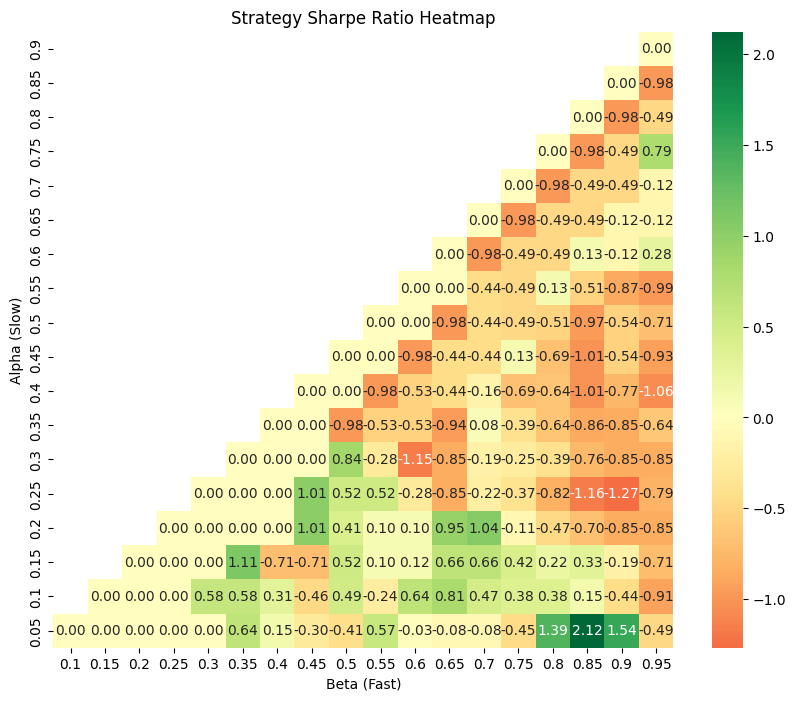


--- PERFORMANCE METRICS ---
Annual Return:     1.93%
Annual Volatility: 0.87%
Sharpe Ratio:      2.1223
Max Drawdown:      -0.36%
Hit Rate:          100.00%
Total Trades:      3
Avg Win:           0.006978909174601237
Avg Loss:          0
Win/Loss Ratio:    0.00


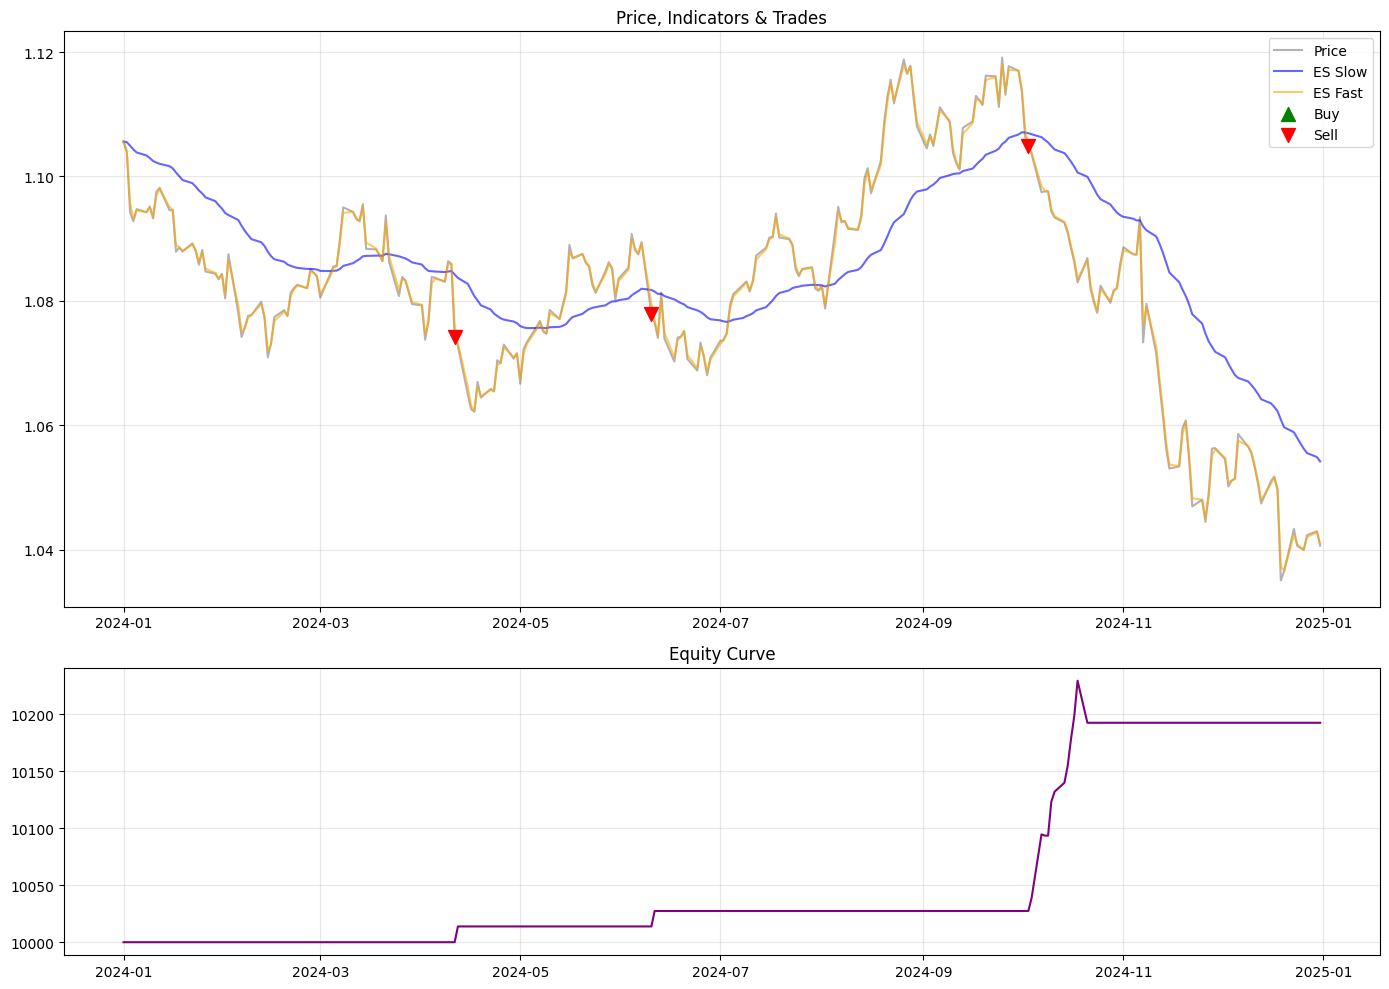

In [9]:
from typing_extensions import deprecated
# 1. Define Ticker and Dates
TICKER = "EURUSD=X" # FX Pair
START = "2024-01-01"
END = "2025-01-01"
threshold = 0.0015
deceleration = 0.005 # exit strategy. Price per Day squared


try:
    # 1. Load Data
  print(f"Downloading {TICKER}...")
  data = get_data(TICKER, START, END, "1d")
  macro_data = get_macro_data(START, END)

  if data.empty:
      print("No data found. Check ticker or dates.")
  else:            # 2. Run Grid Search (Passing your inputs)
      heatmap_matrix, best_params = perform_grid_search(
          data,
          macro_data,
          threshold_input=threshold,
          decel_input=deceleration,
          step=0.05
      )

      if not best_params:
            print("Grid search failed to find valid parameters (possibly all Sharpe Ratios were NaN or negative).")
      else:
            print(f"\nOptimal Parameters Found:")
            print(f"Alpha: {best_params['alpha']:.2f}")
            print(f"Beta:  {best_params['beta']:.2f}")

            plot_heatmap(heatmap_matrix)

                # 3. Run Final Strategy (Passing your inputs)
            final_metrics, final_df, final_trades = run_strategy(
                data,
                macro_data,
                best_params['alpha'],
                best_params['beta'],
                threshold=threshold,
                decel_rate=deceleration
            )

            # 4. Print Metrics
            print("\n--- PERFORMANCE METRICS ---")
            print(f"Annual Return:     {final_metrics['Annual Return']:.2%}")
            print(f"Annual Volatility: {final_metrics['Annual Volatility']:.2%}")
            print(f"Sharpe Ratio:      {final_metrics['Sharpe Ratio']:.4f}")
            print(f"Max Drawdown:      {final_metrics['Max Drawdown']:.2%}")
            print(f"Hit Rate:          {final_metrics['Hit Rate']:.2%}")
            print(f"Total Trades:      {final_metrics['Total Trades']}")
            print(f"Avg Win:           {final_metrics['Avg Win']}")
            print(f"Avg Loss:          {final_metrics['Avg Loss']}")
            print(f"Win/Loss Ratio:    {final_metrics['Win/Loss Ratio']:.2f}")

            # 5. Visualize
            plot_trades(final_df, final_trades)

except Exception as e:
    print(f"An error occurred: {e}")

In [10]:
def comprehensive_grid_search(data, macro_df, alpha_range, beta_range, threshold_range, decel_range, initial_capital=10000):
    """
    Comprehensive grid search over 4 parameters: alpha, beta, threshold, and deceleration.
    Returns top 5 results sorted by Sharpe Ratio.
    Includes macroeconomic variable filtering.

    Parameters:
    -----------
    data : pd.DataFrame
        Price data with 'Close' column
    macro_df : pd.DataFrame
        Macroeconomic signals DataFrame with 'Macro_Signal' column
    alpha_range : array-like
        Range of alpha values to test
    beta_range : array-like
        Range of beta values to test
    threshold_range : array-like
        Range of threshold values to test
    decel_range : array-like
        Range of deceleration values to test
    initial_capital : float
        Starting capital

    Returns:
    --------
    pd.DataFrame
        DataFrame with top 5 results sorted by Sharpe Ratio
    """
    results = []
    total_combinations = len(alpha_range) * len(beta_range) * len(threshold_range) * len(decel_range)
    current = 0

    print(f"Running comprehensive grid search over {total_combinations} combinations...")
    print("This may take a while...\n")

    for alpha in alpha_range:
        for beta in beta_range:
            if alpha >= beta:  # Skip invalid combinations
                continue
            for threshold in threshold_range:
                for decel in decel_range:
                    current += 1
                    if current % 100 == 0:
                        print(f"Progress: {current}/{total_combinations} ({100*current/total_combinations:.1f}%)")

                    try:
                        metrics, _, _ = run_strategy(
                            data,
                            macro_df,
                            alpha,
                            beta,
                            threshold=threshold,
                            decel_rate=decel,
                            initial_capital=initial_capital
                        )

                        results.append({
                            'alpha': alpha,
                            'beta': beta,
                            'threshold': threshold,
                            'deceleration': decel,
                            'Sharpe Ratio': metrics['Sharpe Ratio'],
                            'Annual Return': metrics['Annual Return'],
                            'Annual Volatility': metrics['Annual Volatility'],
                            'Max Drawdown': metrics['Max Drawdown'],
                            'Hit Rate': metrics['Hit Rate'],
                            'Total Trades': metrics['Total Trades'],
                            'Win/Loss Ratio': metrics['Win/Loss Ratio']
                        })
                    except Exception as e:
                        # Skip combinations that cause errors
                        continue

    results_df = pd.DataFrame(results)
    results_df.to_excel("macroeconomic_grid_search.xlsx", sheet_name='Sheet1')

    # Sort by Sharpe Ratio descending and get top 5
    if len(results_df) > 0:
        results_df = results_df.sort_values('Sharpe Ratio', ascending=False)
        top_5 = results_df.head(5).copy()
        print(f"\nGrid search completed! Found {len(results_df)} valid combinations.")
        return top_5
    else:
        print("No valid combinations found!")
        return pd.DataFrame()



In [ ]:
# Define parameter ranges for comprehensive grid search
# Adjust these ranges based on your needs (smaller ranges = faster computation)

# Alpha range (slow smoothing)
alpha_range = np.arange(0.05, 0.5, 0.005)

# Beta range (fast smoothing) - must be > alpha
beta_range = np.arange(0.1, 0.9, 0.005)

# Threshold range
threshold_range = np.array([0.0001, 0.00015, 0.0002, 0.0005, 0.001, 0.0015, 0.002])

# Deceleration range
decel_range = np.array([0.0001, 0.0005, 0.001, 0.002, 0.005, 0.01])

print("Parameter Ranges:")
print(f"Alpha: {alpha_range}")
print(f"Beta: {beta_range}")
print(f"Threshold: {threshold_range}")
print(f"Deceleration: {decel_range}")
print(f"\nTotal combinations to test: {len(alpha_range) * len(beta_range) * len(threshold_range) * len(decel_range)}")



Parameter Ranges:
Alpha: [0.05  0.055 0.06  0.065 0.07  0.075 0.08  0.085 0.09  0.095 0.1   0.105
 0.11  0.115 0.12  0.125 0.13  0.135 0.14  0.145 0.15  0.155 0.16  0.165
 0.17  0.175 0.18  0.185 0.19  0.195 0.2   0.205 0.21  0.215 0.22  0.225
 0.23  0.235 0.24  0.245 0.25  0.255 0.26  0.265 0.27  0.275 0.28  0.285
 0.29  0.295 0.3   0.305 0.31  0.315 0.32  0.325 0.33  0.335 0.34  0.345
 0.35  0.355 0.36  0.365 0.37  0.375 0.38  0.385 0.39  0.395 0.4   0.405
 0.41  0.415 0.42  0.425 0.43  0.435 0.44  0.445 0.45  0.455 0.46  0.465
 0.47  0.475 0.48  0.485 0.49  0.495]
Beta: [0.1   0.105 0.11  0.115 0.12  0.125 0.13  0.135 0.14  0.145 0.15  0.155
 0.16  0.165 0.17  0.175 0.18  0.185 0.19  0.195 0.2   0.205 0.21  0.215
 0.22  0.225 0.23  0.235 0.24  0.245 0.25  0.255 0.26  0.265 0.27  0.275
 0.28  0.285 0.29  0.295 0.3   0.305 0.31  0.315 0.32  0.325 0.33  0.335
 0.34  0.345 0.35  0.355 0.36  0.365 0.37  0.375 0.38  0.385 0.39  0.395
 0.4   0.405 0.41  0.415 0.42  0.425 0.43  0.435 0.44  

In [ ]:
# Run comprehensive grid search with macroeconomic variables
try:
    # Make sure data and macro_data are loaded (from previous cell)
    if 'data' not in locals() or 'macro_data' not in locals():
        print("Loading data and macro data...")
        data = get_data(TICKER, START, END, "1d")
        macro_data = get_macro_data(START, END)

    top_5_results = comprehensive_grid_search(
        data,
        macro_data,
        alpha_range=alpha_range,
        beta_range=beta_range,
        threshold_range=threshold_range,
        decel_range=decel_range,
        initial_capital=10000
    )

    if not top_5_results.empty:
        print("\n" + "="*80)
        print("TOP 5 PARAMETER COMBINATIONS (Sorted by Sharpe Ratio)")
        print("With Macroeconomic Variable Filtering")
        print("="*80)

        # Display top 5 results
        display_cols = ['alpha', 'beta', 'threshold', 'deceleration',
                       'Sharpe Ratio', 'Annual Return', 'Max Drawdown',
                       'Hit Rate', 'Total Trades', 'Win/Loss Ratio']

        top_5_display = top_5_results[display_cols].copy()
        top_5_display['Annual Return'] = top_5_display['Annual Return'].apply(lambda x: f"{x:.2%}")
        top_5_display['Max Drawdown'] = top_5_display['Max Drawdown'].apply(lambda x: f"{x:.2%}")
        top_5_display['Hit Rate'] = top_5_display['Hit Rate'].apply(lambda x: f"{x:.2%}")
        top_5_display['Sharpe Ratio'] = top_5_display['Sharpe Ratio'].apply(lambda x: f"{x:.4f}")
        top_5_display['Win/Loss Ratio'] = top_5_display['Win/Loss Ratio'].apply(lambda x: f"{x:.2f}")

        print(top_5_display.to_string(index=False))

        # Get best combination
        best_combo = top_5_results.iloc[0]
        print("\n" + "="*80)
        print("BEST COMBINATION (With Macro Variables):")
        print("="*80)
        print(f"Alpha:        {best_combo['alpha']:.4f}")
        print(f"Beta:         {best_combo['beta']:.4f}")
        print(f"Threshold:    {best_combo['threshold']:.6f}")
        print(f"Deceleration: {best_combo['deceleration']:.6f}")
        print(f"\nPerformance Metrics:")
        print(f"  Sharpe Ratio:      {best_combo['Sharpe Ratio']:.4f}")
        print(f"  Annual Return:     {best_combo['Annual Return']:.2%}")
        print(f"  Annual Volatility:  {best_combo['Annual Volatility']:.2%}")
        print(f"  Max Drawdown:      {best_combo['Max Drawdown']:.2%}")
        print(f"  Hit Rate:          {best_combo['Hit Rate']:.2%}")
        print(f"  Total Trades:      {int(best_combo['Total Trades'])}")
        print(f"  Win/Loss Ratio:    {best_combo['Win/Loss Ratio']:.2f}")

    else:
        print("No valid results found!")

except Exception as e:
    print(f"An error occurred during comprehensive grid search: {e}")
    import traceback
    traceback.print_exc()



Running comprehensive grid search over 604800 combinations...
This may take a while...

Progress: 100/604800 (0.0%)
Progress: 200/604800 (0.0%)
Progress: 300/604800 (0.0%)
Progress: 400/604800 (0.1%)
Progress: 500/604800 (0.1%)
Progress: 600/604800 (0.1%)
Progress: 700/604800 (0.1%)
Progress: 800/604800 (0.1%)
Progress: 900/604800 (0.1%)
Progress: 1000/604800 (0.2%)
Progress: 1100/604800 (0.2%)
Progress: 1200/604800 (0.2%)
Progress: 1300/604800 (0.2%)
Progress: 1400/604800 (0.2%)
Progress: 1500/604800 (0.2%)
Progress: 1600/604800 (0.3%)
Progress: 1700/604800 (0.3%)
Progress: 1800/604800 (0.3%)
Progress: 1900/604800 (0.3%)
Progress: 2000/604800 (0.3%)
Progress: 2100/604800 (0.3%)
Progress: 2200/604800 (0.4%)
Progress: 2300/604800 (0.4%)
Progress: 2400/604800 (0.4%)
Progress: 2500/604800 (0.4%)
Progress: 2600/604800 (0.4%)
Progress: 2700/604800 (0.4%)
Progress: 2800/604800 (0.5%)
Progress: 2900/604800 (0.5%)
Progress: 3000/604800 (0.5%)
Progress: 3100/604800 (0.5%)
Progress: 3200/604800 


VISUALIZATION OF BEST COMBINATION (With Macro Variables)


/tmp/ipython-input-2465355838.py:112: UserWarning: This figure includes Axes that are not compatible with tight_layout, so results might be incorrect.
  plt.tight_layout()


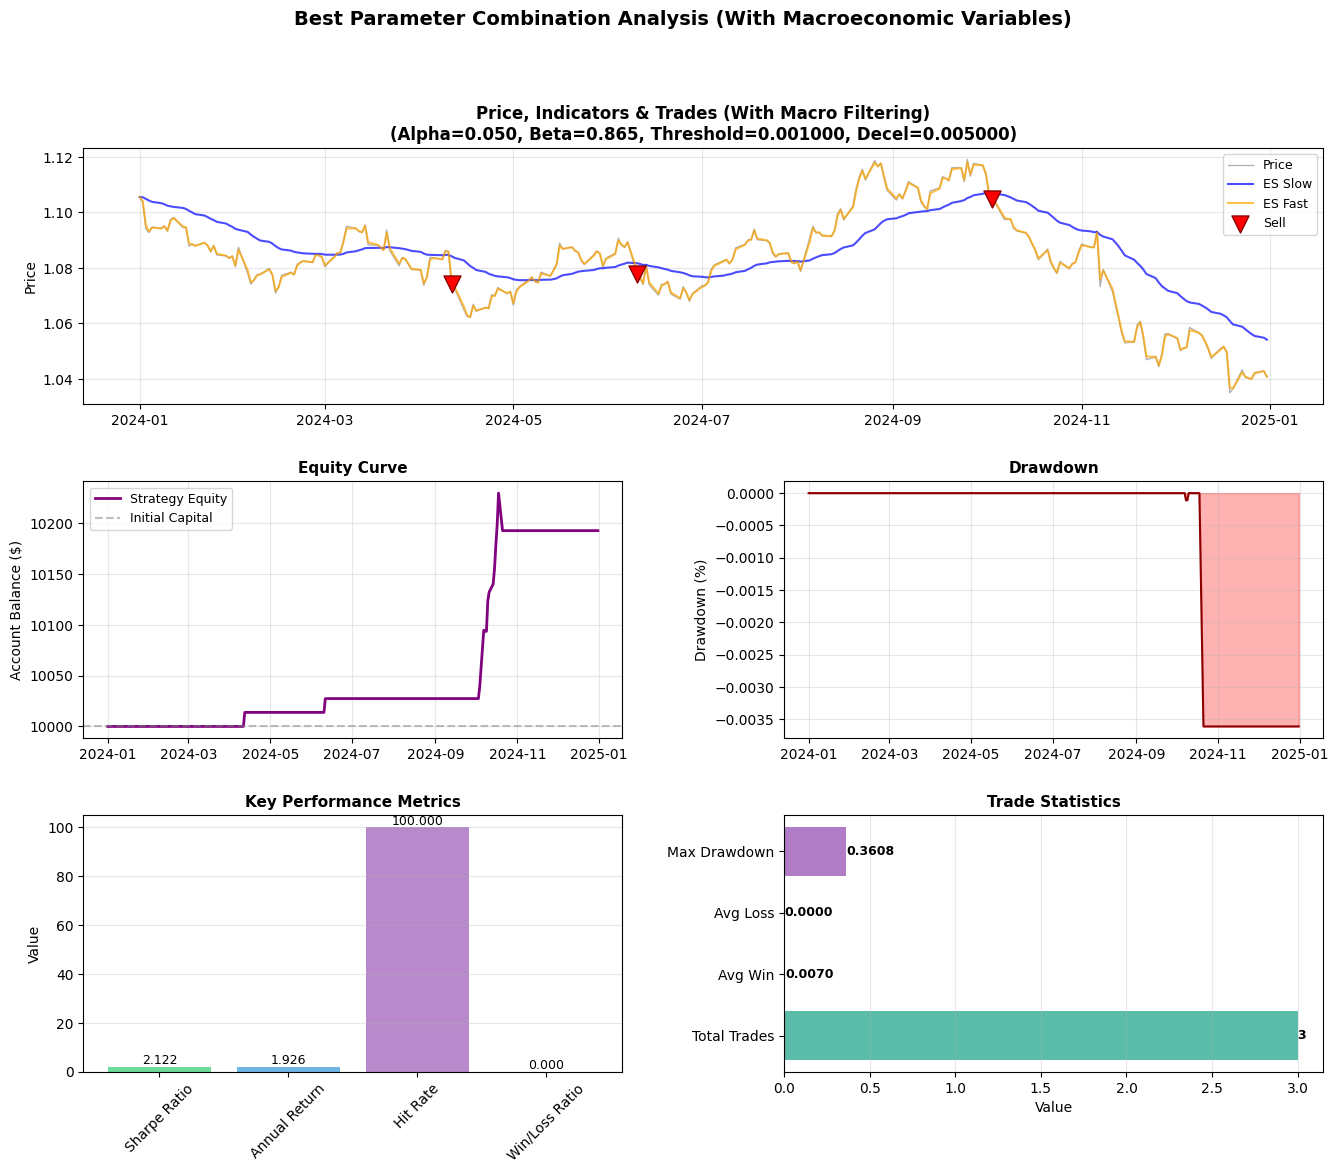


Visualization complete!


In [ ]:
# Visualize the best combination with macroeconomic variables
if not top_5_results.empty:
    best_combo = top_5_results.iloc[0]

    # Run strategy with best parameters
    best_metrics, best_df, best_trades = run_strategy(
        data,
        macro_data,
        best_combo['alpha'],
        best_combo['beta'],
        threshold=best_combo['threshold'],
        decel_rate=best_combo['deceleration'],
        initial_capital=10000
    )

    print("\n" + "="*80)
    print("VISUALIZATION OF BEST COMBINATION (With Macro Variables)")
    print("="*80)

    # Create comprehensive visualization
    fig = plt.figure(figsize=(16, 12))
    gs = fig.add_gridspec(3, 2, hspace=0.3, wspace=0.3)

    # Plot 1: Price, Indicators & Trades (Top Left, spanning 2 columns)
    ax1 = fig.add_subplot(gs[0, :])
    ax1.plot(best_df.index, best_df['Close'], label='Price', color='black', alpha=0.3, linewidth=1)
    ax1.plot(best_df.index, best_df['es_slow'], label='ES Slow', color='blue', alpha=0.7, linewidth=1.5)
    ax1.plot(best_df.index, best_df['es_fast'], label='ES Fast', color='orange', alpha=0.7, linewidth=1.5)

    if not best_trades.empty:
        buys = best_trades[best_trades['Type'] == 'Buy']
        if not buys.empty:
            ax1.scatter(buys['Date'], buys['Price'], marker='^', color='green',
                       s=150, label='Buy', zorder=5, edgecolors='darkgreen', linewidths=1)

        sells = best_trades[best_trades['Type'] == 'Sell']
        if not sells.empty:
            ax1.scatter(sells['Date'], sells['Price'], marker='v', color='red',
                       s=150, label='Sell', zorder=5, edgecolors='darkred', linewidths=1)

    ax1.set_title(f"Price, Indicators & Trades (With Macro Filtering)\n(Alpha={best_combo['alpha']:.3f}, Beta={best_combo['beta']:.3f}, "
                  f"Threshold={best_combo['threshold']:.6f}, Decel={best_combo['deceleration']:.6f})",
                  fontsize=12, fontweight='bold')
    ax1.set_ylabel("Price", fontsize=10)
    ax1.legend(loc='best', fontsize=9)
    ax1.grid(True, alpha=0.3)

    # Plot 2: Equity Curve (Middle Left)
    ax2 = fig.add_subplot(gs[1, 0])
    ax2.plot(best_df.index, best_df['Equity'], color='purple', linewidth=2, label='Strategy Equity')
    ax2.axhline(y=10000, color='gray', linestyle='--', alpha=0.5, label='Initial Capital')
    ax2.set_title("Equity Curve", fontsize=11, fontweight='bold')
    ax2.set_ylabel("Account Balance ($)", fontsize=10)
    ax2.legend(fontsize=9)
    ax2.grid(True, alpha=0.3)

    # Plot 3: Drawdown (Middle Right)
    ax3 = fig.add_subplot(gs[1, 1])
    rolling_max = best_df['Equity'].cummax()
    drawdown = (best_df['Equity'] - rolling_max) / rolling_max
    ax3.fill_between(best_df.index, drawdown, 0, color='red', alpha=0.3)
    ax3.plot(best_df.index, drawdown, color='darkred', linewidth=1.5)
    ax3.set_title("Drawdown", fontsize=11, fontweight='bold')
    ax3.set_ylabel("Drawdown (%)", fontsize=10)
    ax3.grid(True, alpha=0.3)

    # Plot 4: Performance Metrics Bar Chart (Bottom Left)
    ax4 = fig.add_subplot(gs[2, 0])
    metrics_to_plot = {
        'Sharpe Ratio': best_metrics['Sharpe Ratio'],
        'Annual Return': best_metrics['Annual Return'] * 100,  # Convert to percentage
        'Hit Rate': best_metrics['Hit Rate'] * 100,
        'Win/Loss Ratio': best_metrics['Win/Loss Ratio']
    }
    bars = ax4.bar(metrics_to_plot.keys(), metrics_to_plot.values(),
                   color=['#2ecc71', '#3498db', '#9b59b6', '#e74c3c'], alpha=0.7)
    ax4.set_title("Key Performance Metrics", fontsize=11, fontweight='bold')
    ax4.set_ylabel("Value", fontsize=10)
    ax4.tick_params(axis='x', rotation=45)
    ax4.grid(True, alpha=0.3, axis='y')

    # Add value labels on bars
    for bar in bars:
        height = bar.get_height()
        ax4.text(bar.get_x() + bar.get_width()/2., height,
                f'{height:.3f}',
                ha='center', va='bottom', fontsize=9)

    # Plot 5: Trade Statistics (Bottom Right)
    ax5 = fig.add_subplot(gs[2, 1])
    if not best_trades.empty:
        trade_stats = {
            'Total Trades': int(best_metrics['Total Trades']),
            'Avg Win': best_metrics['Avg Win'],
            'Avg Loss': abs(best_metrics['Avg Loss']),
            'Max Drawdown': abs(best_metrics['Max Drawdown']) * 100
        }
        stats_labels = list(trade_stats.keys())
        stats_values = list(trade_stats.values())
        bars2 = ax5.barh(stats_labels, stats_values, color=['#16a085', '#27ae60', '#c0392b', '#8e44ad'], alpha=0.7)
        ax5.set_title("Trade Statistics", fontsize=11, fontweight='bold')
        ax5.set_xlabel("Value", fontsize=10)
        ax5.grid(True, alpha=0.3, axis='x')

        # Add value labels
        for i, (bar, val) in enumerate(zip(bars2, stats_values)):
            ax5.text(val, i, f'{val:.4f}' if val < 1 else f'{int(val)}',
                    va='center', ha='left', fontsize=9, fontweight='bold')
    bec
    plt.suptitle("Best Parameter Combination Analysis (With Macroeconomic Variables)",
                 fontsize=14, fontweight='bold', y=0.995)
    plt.tight_layout()
    plt.show()

    print("\nVisualization complete!")

